# Time-energy fit

3ML allows the possibility to model a time-varying source by explicitly fitting the time-dependent part of the model. Let's see this with an example.

First we import what we need:


In [1]:
import warnings

warnings.simplefilter("ignore")
import numpy as np

np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
%%capture
import matplotlib.pyplot as plt

# import matplotlib.animation as animation

from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:
from jupyterthemes import jtplot

%matplotlib inline
jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()
silence_warnings()

## Generating the datasets

Then we generate a simulated dataset for a source with a cutoff powerlaw spectrum with a constant photon index and cutoff but with a normalization that changes with time following a powerlaw:

In [4]:
def generate_one(K):
    # Let's generate some data with y = Powerlaw(x)

    gen_function = Cutoff_powerlaw()
    gen_function.K = K

    # Generate a dataset using the power law, and a
    # constant 30% error

    x = np.logspace(0, 2, 50)

    xyl_generator = XYLike.from_function(
        "sim_data", function=gen_function, x=x, yerr=0.3 * gen_function(x)
    )

    y = xyl_generator.y
    y_err = xyl_generator.yerr

    return x, y, y_err

These are the times at which the simulated spectra have been observed

In [5]:
time_tags = np.array([1.0, 2.0, 5.0, 10.0])

This describes the time-varying normalization. If everything works as it should, we should recover from the fit a normalization of 0.23 and a index of -1.2 for the time law.

In [6]:
normalizations = 0.23 * time_tags ** (-3.5)

Now that we have a simple function to create the datasets, let's build them.

18:43:37 INFO      Using Gaussian statistic (equivalent to chi^2) with the provided errors.            ]8;id=808238;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py\XYLike.py]8;;\:]8;id=391455;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py#93\93]8;;\

18:43:38 INFO      Using Gaussian statistic (equivalent to chi^2) with the provided errors.            ]8;id=564141;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py\XYLike.py]8;;\:]8;id=579573;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py#93\93]8;;\

         INFO      Using Gaussian statistic (equivalent to chi^2) with the provided errors.            ]8;id=244212;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py\XYLike.py]8;;\:]8;id=875309;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py#93\93]8;;\

         INFO      Using Gaussian statistic (equivalent to chi^2) with the provided errors.            ]8;id=68036;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py\XYLike.py]8;;\:]8;id=925115;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py#93\93]8;;\

         INFO      Using Gaussian statistic (equivalent to chi^2) with the provided errors.            ]8;id=399887;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py\XYLike.py]8;;\:]8;id=785777;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py#93\93]8;;\

         INFO      Using Gaussian statistic (equivalent to chi^2) with the provided errors.            ]8;id=311271;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py\XYLike.py]8;;\:]8;id=560630;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py#93\93]8;;\

         INFO      Using Gaussian statistic (equivalent to chi^2) with the provided errors.            ]8;id=645773;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py\XYLike.py]8;;\:]8;id=363090;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py#93\93]8;;\

         INFO      Using Gaussian statistic (equivalent to chi^2) with the provided errors.            ]8;id=408148;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py\XYLike.py]8;;\:]8;id=408582;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py#93\93]8;;\

Text(0, 0.5, 'Flux')

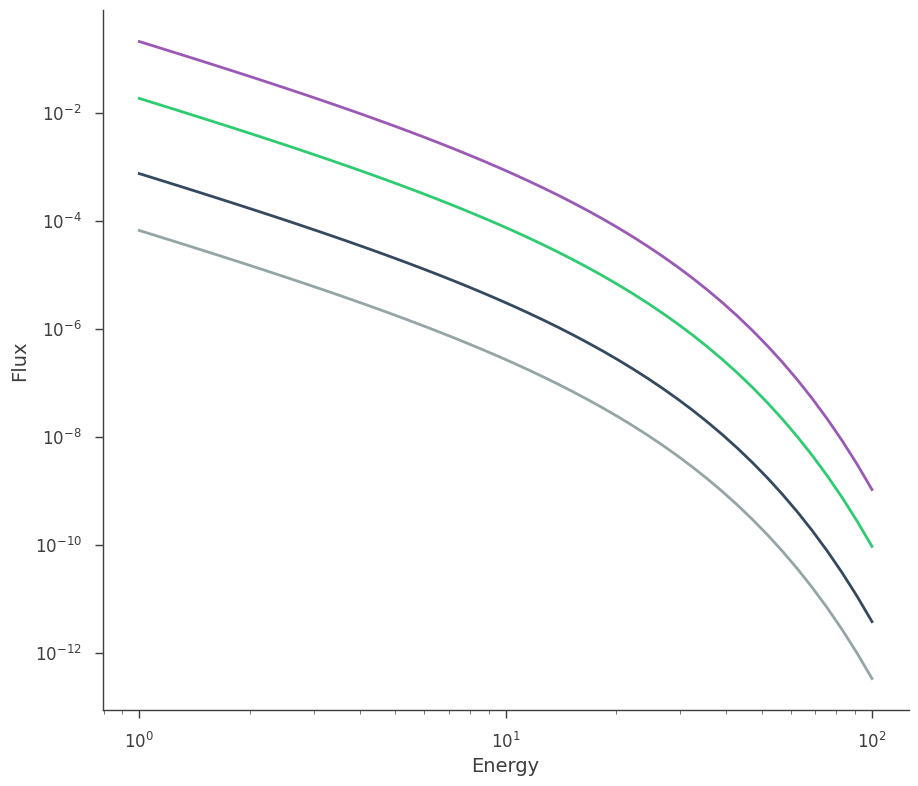

In [7]:

datasets = [generate_one(k) for k in normalizations]

x = np.logspace(0, 2, 50)

fig, ax = plt.subplots()


for k in normalizations:
    gen_function = Cutoff_powerlaw()
    gen_function.K = k
    ax.loglog(x, gen_function(x))

ax.set_xlabel("Energy")
ax.set_ylabel("Flux")

## Setup the model

Now set up the fit and fit it. First we need to tell 3ML that we are going to fit using an independent variable (time in this case). We init it to 1.0 and set the unit to seconds.

In [8]:
time = IndependentVariable("time", 1.0, u.s)

Then we load the data that we have generated, tagging them with their time of observation.

In [9]:

plugins = []

for i, dataset in enumerate(datasets):
    x, y, y_err = dataset

    xyl = XYLike("data%i" % i, x, y, y_err)

    # This is the important part: we need to tag the instance of the
    # plugin so that 3ML will know that this instance corresponds to the
    # given tag (a time coordinate in this case). If instead of giving
    # one time coordinate we give two time coordinates, then 3ML will
    # take the average of the model between the two time coordinates
    # (computed as the integral of the model between t1 and t2 divided
    # by t2-t1)

    xyl.tag = (time, time_tags[i])

    # To access the tag we have just set we can use:

    independent_variable, start, end = xyl.tag

    # NOTE: xyl.tag will return 3 things: the independent variable, the start and the
    # end. If like in this case you do not specify an end when assigning the tag, end
    # will be None

    plugins.append(xyl)

18:43:39 INFO      Using Gaussian statistic (equivalent to chi^2) with the provided errors.            ]8;id=521673;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py\XYLike.py]8;;\:]8;id=143022;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py#93\93]8;;\

         INFO      Using Gaussian statistic (equivalent to chi^2) with the provided errors.            ]8;id=207350;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py\XYLike.py]8;;\:]8;id=504740;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py#93\93]8;;\

         INFO      Using Gaussian statistic (equivalent to chi^2) with the provided errors.            ]8;id=452186;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py\XYLike.py]8;;\:]8;id=497167;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py#93\93]8;;\

         INFO      Using Gaussian statistic (equivalent to chi^2) with the provided errors.            ]8;id=845839;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py\XYLike.py]8;;\:]8;id=970944;file:///home/runner/work/threeML/threeML/threeML/plugins/XYLike.py#93\93]8;;\

Generate the datalist as usual



In [10]:
data = DataList(*plugins)

Now let's generate the spectral model, in this case a point source with a cutoff powerlaw spectrum.

In [11]:
spectrum = Cutoff_powerlaw()

src = PointSource("test", ra=0.0, dec=0.0, spectral_shape=spectrum)

model = Model(src)

Now we need to tell 3ML that we are going to use the time coordinate to specify a time dependence for some of the parameters of the model.



In [12]:
model.add_independent_variable(time)

Now let's specify the time-dependence (a powerlaw) for the normalization of the powerlaw spectrum.

In [13]:
time_po = Powerlaw()
time_po.K.bounds = (0.01, 1000)

Link the normalization of the cutoff powerlaw spectrum with time through the time law we have just generated.

In [14]:
model.link(spectrum.K, time, time_po)
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (4):
--------------------

                                         value min_value max_value  \
test...K                                   1.0      0.01    1000.0   
test...index                             -2.01     -10.0      10.0   
test.spectrum.main.Cutoff_powerlaw.index  -2.0     -10.0      10.0   
test.spectrum.main.Cutoff_powerlaw.xc     10.0       1.0      None   

                                                    unit  
test...K                                  keV-1 s-1 cm-2  
test...index                                              
test.spectrum.main.Cutoff_powerlaw.index                  
test.spectrum.main.Cutoff_powerlaw.xc                keV  

Fixed parameters (4):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (1):
----------------------

              test.spectrum.main.Cutoff_powerlaw.K
linked to                                     time
function                                  Powerlaw
current value                                  1.0
unit                               1 / (keV s cm2)


Independent variables:
----------------------

              time
current value  1.0
unit             s


Linked functions (0):
----------------------

(none)

## Performing the fit

In [15]:
jl = JointLikelihood(model, data)

best_fit_parameters, likelihood_values = jl.fit()

         INFO      set the minimizer to minuit                                             ]8;id=361390;file:///home/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=2308;file:///home/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

Best fit values:

,result,unit
parameter,,
test.spectrum.main.Cutoff_powerlaw.K.Powerlaw.K,(2.36 -0.13 +0.14) x 10^-1,1 / (keV s cm2)
test...index,-3.523 +/- 0.025,
test.spectrum.main.Cutoff_powerlaw.index,-2.022 +/- 0.031,
test.spectrum.main.Cutoff_powerlaw.xc,(1.024 -0.016 +0.017) x 10,keV


Correlation matrix:

1.00,-0.48,-0.72,0.48
-0.48,1.00,-0.01,0.01
-0.72,-0.01,1.00,-0.88
0.48,0.01,-0.88,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
data0,18.964130
data1,18.894229
data2,27.614631
data3,23.439679
total,88.912670


Values of statistical measures:

,statistical measures
AIC,186.030467
BIC,199.018609


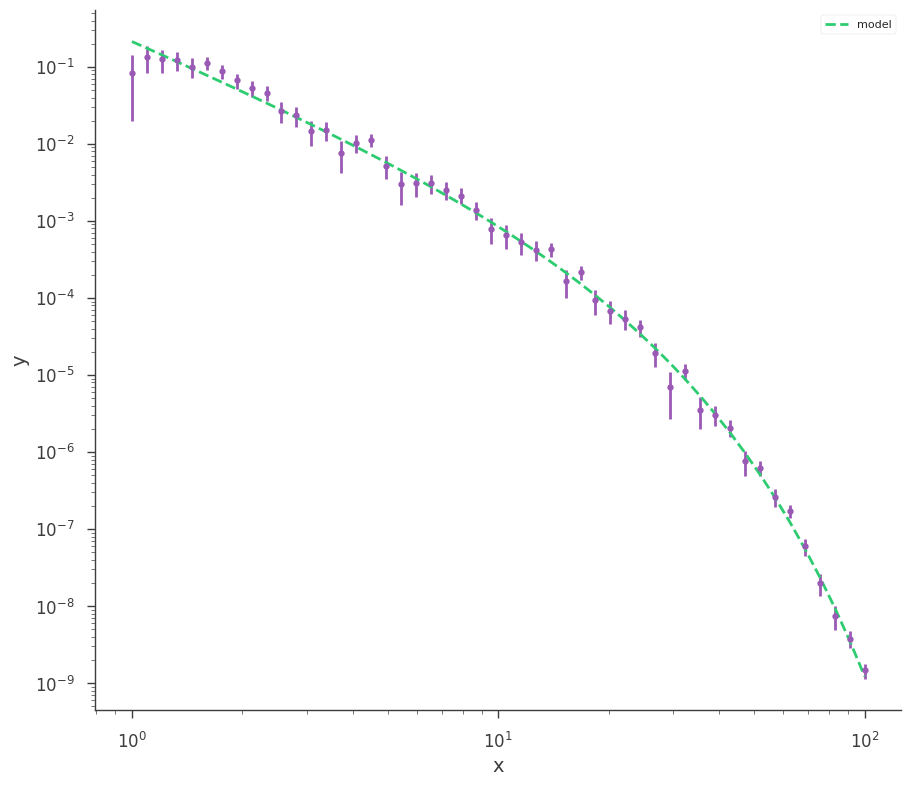

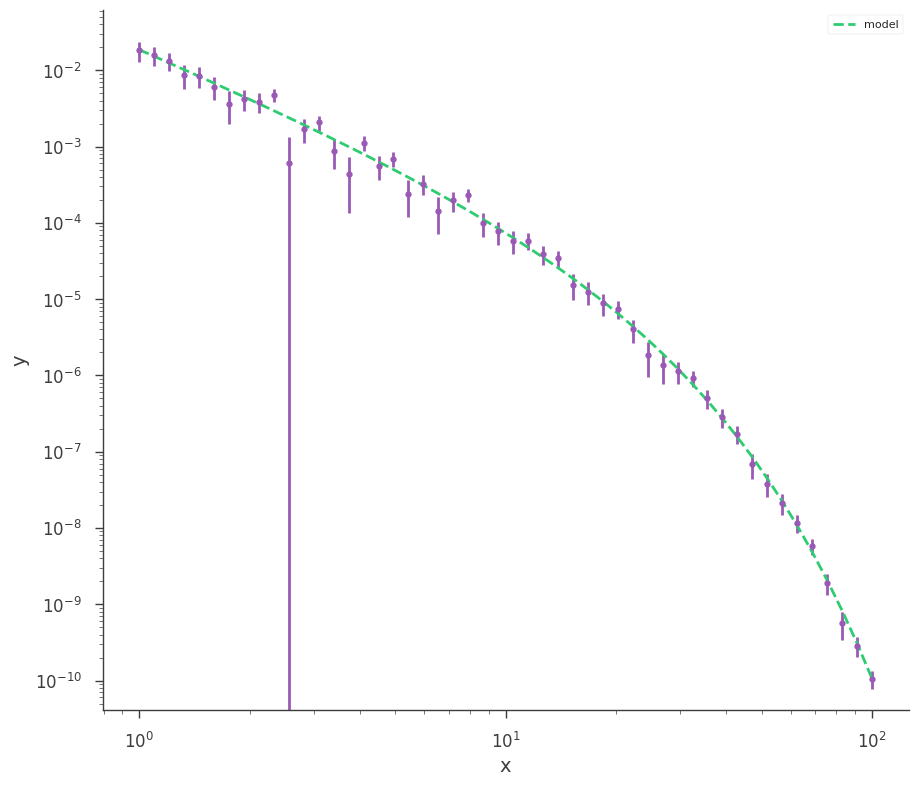

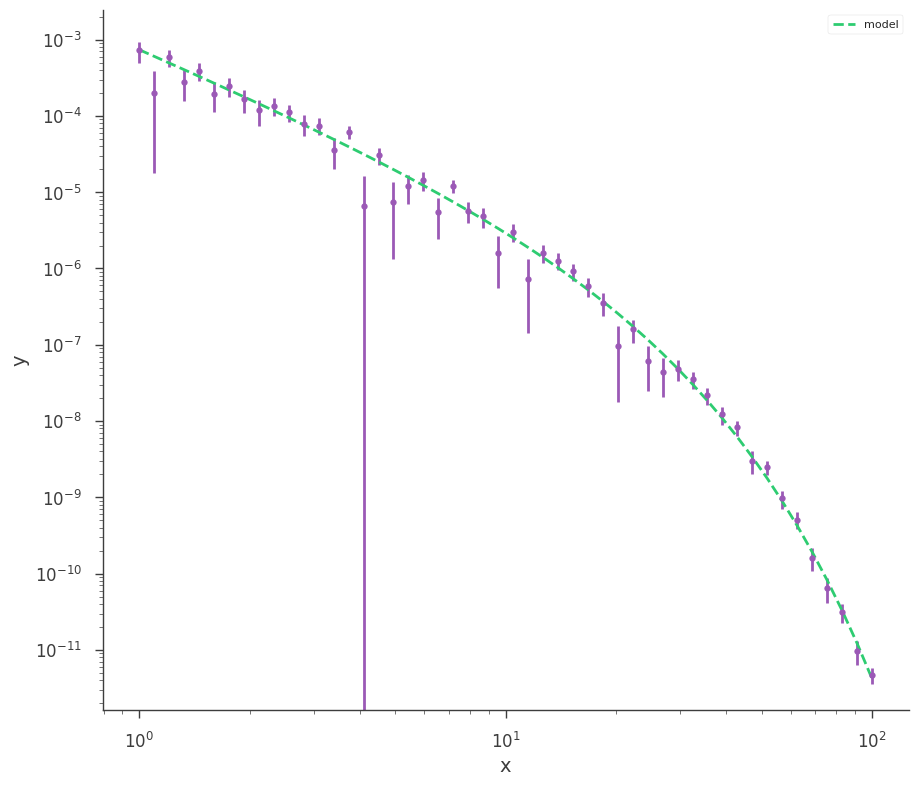

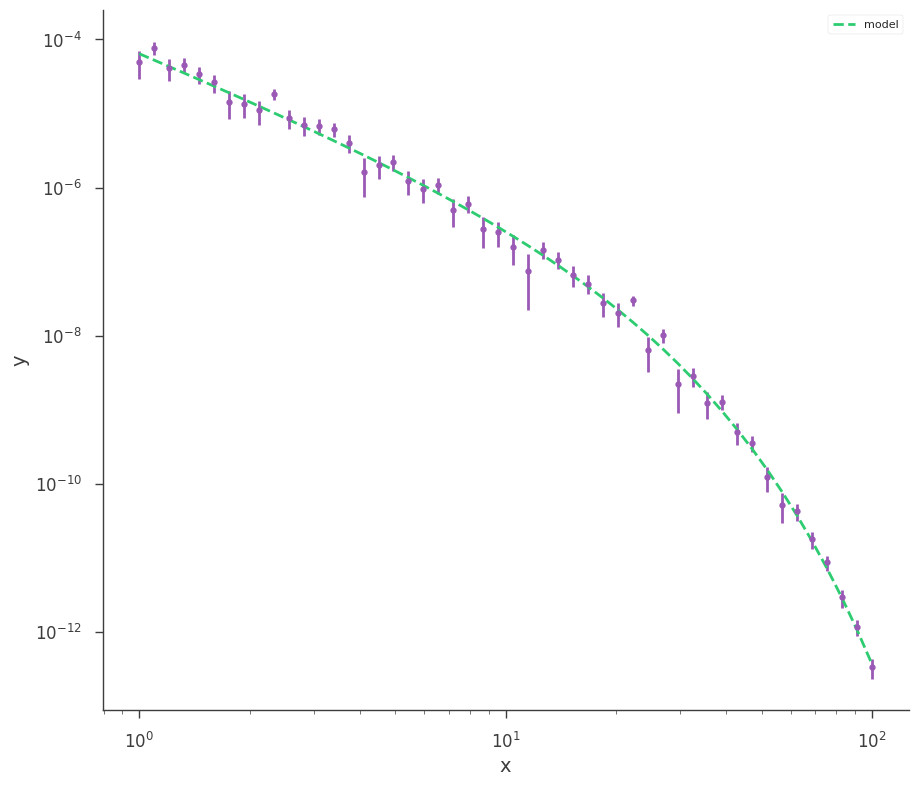

In [16]:
for p in plugins:
    _ = p.plot(x_scale="log", y_scale="log")